# Software installation

In [ ]:
!pwd

/content


The code below needs to run in colab

In [1]:
#Install collab
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
import os
home=os.getcwd()
os.chdir(home)

#Download OpenMM-Plumed-MPI patch
!conda install -y -c conda-forge mpich mpi4py openmm=8.0 plumed=2.8.2=mpi_mpich_h7ded119_0 py-plumed cmake swig pandas mdtraj biopython matplotlib gromacs
!conda install -y -c anaconda ipykernel
!conda install -y -c bioconda pulchra

!git clone https://github.com/vendruscolo-lab/OpenMM-Plumed-MPI

os.chdir(home+'/OpenMM-Plumed-MPI')

#Build openmm-plumed-mpi
!mkdir build install openmm -p plumed/include -p plumed/lib
!unzip openmm.zip -d openmm
!unzip plumed_lib.zip -d plumed/lib
!unzip plumed_include.zip -d plumed/include
os.chdir(os.getcwd()+'/build')
!cmake ..
!make
!make install
!make PythonInstall
os.chdir(os.getcwd()+'/../install/lib')
!cp -r * /usr/local/lib/

Streaming output truncated to the last 5000 lines.




libclang13-15.0.7    | 9.1 MB    | :  29% 0.29233532566742776/1 [00:05<00:09, 13.18s/it]












libopenblas-0.3.28   | 5.3 MB    | :  15% 0.14701519844987979/1 [00:05<00:15, 17.74s/it]











numpy-1.26.4         | 6.7 MB    | :  15% 0.15194027167655624/1 [00:05<00:13, 15.42s/it]









libclang13-15.0.7    | 9.1 MB    | :  31% 0.3128500853633876/1 [00:05<00:07, 11.62s/it] 










matplotlib-base-3.9. | 6.7 MB    | :  13% 0.1283979607248603/1 [00:05<00:14, 16.69s/it] 












libopenblas-0.3.28   | 5.3 MB    | :  18% 0.18229884607785093/1 [00:05<00:10, 12.52s/it]











numpy-1.26.4         | 6.7 MB    | :  18% 0.1799907833706897/1 [00:05<00:09, 11.47s/it] 










matplotlib-base-3.9. | 6.7 MB    | :  16% 0.156412061246648/1 [00:05<00:10, 12.10s/it] 









libclang13-15.0.7    | 9.1 MB    | :  33% 0.33336484505934744/1 [00:05<00:06, 10.23s/it]












libopenblas-0.3.28   | 5.3 MB    | :  22% 0.22052

In [2]:
!pwd

/content/OpenMM-Plumed-MPI/install/lib


# Run Alpha-Fold distance map prediction


__For this example (TDP-43 WtoA):__

The AF distance map has already been calculated and it is loaded in this notebook below.

__For arbitrary protein sequences:__

*   Open [this](https://github.com/zshengyu14/ColabFold_distmats/blob/main/AlphaFold2.ipynb) link and chose colab.
*   Input the protein sequence  as query sequence.
*   The rest of the options remain default and cells are run until the end.
*   Download the link with the AF data and upload it as AF_data in AlphaFold-IDP folder

# Setup protein system in CALVADOS and OPENMM

In [3]:
os.chdir(home)
!git clone https://github.com/vendruscolo-lab/AlphaFold-IDP

Cloning into 'AlphaFold-IDP'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 302 (delta 94), reused 171 (delta 66), pack-reused 89 (from 1)
Receiving objects: 100% (302/302), 53.97 MiB | 23.86 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [4]:
os.chdir(home+'/AlphaFold-IDP/prep_run')


In [5]:
import shutil
import csv
dir=os.getcwd()
###################### The entries below need to be adapted in eac simulation ######################
#TDP-43 sequence
fasta_sequence="MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNPVSQCMRGVRLVEGILHAPDAGAGNLVYVVNYPKDNKRKMDETDASSAVKVKRAVQKTSDLIVLGLPAKTTEQDLKEYFSTFGEVLMVQVKKDLKTGHSKGFGFVRFTEYETQVKVMSQRHMIDGRACDCKLPNSKQSQDEPLRSRKVFVGRCTEDMTEDELREFFSQYGDVMDVFIPKPFRAFAFVTFADDQIAQSLCGEDLIIKGISVHISNAEPKHNSNRQLERSGRFGGNPGGFGNQGGFGNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSAGMMGMLASQQNQSGPSGNNQNQGNMQREPNQAFGSGNNSYSGSNSGAAIGAGSASNAGSGSGFNGGFGSSMDSKSSGAGM"
#Conditions
pH=7.4
temp=298
ionic=0.2
PAE_cut=5
Pr_cut=0.2
NR=4
#Decide the plddt based ordered (od) and disordered (dd) regions
ordered_domains = {'od1': [3, 79], 'od2': [104,178],'od3':[191,260]}
disordered_domains={'dd1': [1,2],'dd2':[80,103],'dd3':[179,190],'dd4':[261,414]}

#AF input created in AF-distance map prediction and used in AF-MI
pdb_af='tdp43_WtoA_bf4cc_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb'
json_af='tdp43_WtoA_bf4cc_predicted_aligned_error_v1.json'
npy_af='alphafold2_ptm_model_3_seed_000_prob_distributions.npy'
mean_af='alphafold2_ptm_model_3_seed_000_mean.csv'
#Copy AF data
shutil.copy2(dir+"/../AF_DATA/"+pdb_af, dir+"/pdb_af.pdb")
shutil.copy2(dir+"/../AF_DATA/"+json_af, dir+"/pae.json")
shutil.copy2(dir+"/../AF_DATA/tdp43_WtoA_bf4cc_distmat/"+mean_af, dir+"/mean_af.csv")
shutil.copy2(dir+"/../AF_DATA/tdp43_WtoA_bf4cc_distmat/"+npy_af, dir+"/prob.npy")
####################################################################################################

f = open("sequence.dat", "w")
f.write(fasta_sequence)
f.close()
#Write the csv files
with open('ordered_domains.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, ordered_domains.keys())
    w.writeheader()
    w.writerow(ordered_domains)
with open('disordered_domains.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, disordered_domains.keys())
    w.writeheader()
    w.writerow(disordered_domains)

#Copy OPENMM calvados forcefield files
shutil.copy2(dir+"/../scripts_prep/gen_xml_and_constraints.py", dir)
shutil.copy2(dir+"/../scripts_prep/residues.csv", dir)

path_gen_xml = dir+'/gen_xml_and_constraints.py sequence.dat '+str(pH)+' '+str(temp)+' '+str(ionic)
print(path_gen_xml)
os.system(f'python {path_gen_xml}')



/content/AlphaFold-IDP/prep_run/gen_xml_and_constraints.py sequence.dat 7.4 298 0.2


0

In [6]:
#Make plumed files.
#Copy and run the prep script that makes the plumed file.
#The Collective variables (CVs) in these case are chosen to be the torsion angles between structured domains.
import subprocess
shutil.copy2(dir+"/../scripts_prep/make_plumed_distmat.py", dir)
subprocess.run(['python', str(dir)+'/make_plumed_distmat.py', 'sequence.dat',str(PAE_cut), str(Pr_cut)], capture_output=True, text=True)

CompletedProcess(args=['python', '/content/AlphaFold-IDP/prep_run/make_plumed_distmat.py', 'sequence.dat', '5', '0.2'], returncode=0, stdout="5.0 0.2\n[[3, 79], [104, 178], [191, 260]]\n       od1         od2         od3\n0  [3, 79]  [104, 178]  [191, 260]\n[[1, 2], [80, 103], [179, 190], [261, 414]]\n      dd1        dd2         dd3         dd4\n0  [1, 2]  [80, 103]  [179, 190]  [261, 414]\n1 4\n1 5\n1 6\n1 7\n1 8\n1 9\n1 10\n1 11\n1 12\n1 13\n1 14\n1 15\n1 16\n1 17\n1 18\n1 19\n1 20\n1 21\n1 22\n1 23\n1 24\n1 25\n1 26\n1 27\n1 28\n1 29\n1 30\n1 31\n1 32\n1 33\n1 34\n1 35\n1 36\n1 37\n1 38\n1 39\n1 40\n1 41\n1 42\n1 43\n1 44\n1 45\n1 46\n1 47\n1 48\n1 49\n1 50\n1 51\n1 52\n1 53\n1 54\n1 55\n1 56\n1 57\n1 58\n1 59\n1 60\n1 61\n1 62\n1 63\n1 64\n1 65\n1 66\n1 67\n1 68\n1 69\n1 70\n1 71\n1 72\n1 73\n1 74\n1 75\n1 76\n1 77\n1 78\n1 79\n1 80\n1 81\n1 82\n1 83\n1 84\n1 85\n1 86\n1 87\n1 88\n1 89\n1 90\n1 91\n1 92\n1 93\n1 94\n1 95\n1 96\n1 97\n1 98\n1 99\n1 100\n1 101\n1 102\n1 103\n1 104\n

In [7]:
!cat plumed.dat

MOLINFO MOLTYPE=protein STRUCTURE=input_af.pdb
WHOLEMOLECULES ENTITY0=1-414

distance_rest_domains:  CONTACTMAP ...
ATOMS1=1,4
ATOMS2=2,5
ATOMS3=2,20
ATOMS4=28,79
ATOMS5=31,79
ATOMS6=35,79
ATOMS7=37,79
ATOMS8=38,79
ATOMS9=39,79
ATOMS10=40,79
ATOMS11=41,79
ATOMS12=42,79
ATOMS13=74,79
ATOMS14=75,79
ATOMS15=76,79
ATOMS16=102,105
ATOMS17=102,106
ATOMS18=102,150
ATOMS19=102,151
ATOMS20=102,152
ATOMS21=102,155
ATOMS22=102,158
ATOMS23=102,159
ATOMS24=102,161
ATOMS25=103,106
ATOMS26=103,107
ATOMS27=103,108
ATOMS28=103,120
ATOMS29=103,121
ATOMS30=103,124
ATOMS31=103,130
ATOMS32=103,131
ATOMS33=103,132
ATOMS34=103,133
ATOMS35=103,134
ATOMS36=103,135
ATOMS37=103,147
ATOMS38=103,148
ATOMS39=103,149
ATOMS40=103,150
ATOMS41=103,151
ATOMS42=103,152
ATOMS43=103,153
ATOMS44=103,154
ATOMS45=103,155
ATOMS46=103,156
ATOMS47=103,157
ATOMS48=103,158
ATOMS49=103,159
ATOMS50=103,160
ATOMS51=103,161
ATOMS52=103,162
ATOMS53=103,175
ATOMS54=103,176
ATOMS55=103,177
ATOMS56=103,178
ATOMS57=104,178
ATOMS58=105,178


In [8]:
#Make the plumed_analysis.dat file
shutil.copy2(dir+"/../scripts_prep/make_plumed_analysis.py", dir)
path_gen_analysis = dir+'/make_plumed_analysis.py sequence.dat'
os.system(f'python {path_gen_analysis}')



0

__Note:__ that users needs to fill in the respective PLUMED (_ _FILL _ _) PBMETAD and Metainference parameters according to the problem in need.

__Note:__ This tutorial assumes that you know [Parallel Bias Metadynamics](https://www.plumed.org/doc-v2.9/user-doc/html/_p_b_m_e_t_a_d.html) and [Metainference](https://link.springer.com/content/pdf/10.1007/978-1-4939-9608-7_13.pdf) theory and practice.


### In case you are running the TDP-43 WtoA example:

You can directly use the PBMetaD and Metainference parameters just as copied below by executing the next shell. Otherwise you need to define your system specific parameters.

In [9]:
shutil.copy2(dir+"/../scripts_prep/plumed_TDP-43.dat", dir+'/plumed.dat')
shutil.copy2(dir+"/../scripts_prep/plumed_analysis_TDP-43.dat", dir+'/plumed_analysis.dat')


'/content/AlphaFold-IDP/prep_run/plumed_analysis.dat'

# Energy minimization

In [10]:
#Activate the conda openmm-plumed environment
shutil.copy2(dir+"/../scripts_prep/simulate_em.py", dir)
#First run a short minimization
simulate_em = dir+'/simulate_em.py '+str(pH)+' '+str(temp)

os.system(f'python {simulate_em}')



0

# Run AF-MI

In [36]:
#and run AF-MI
shutil.copy2(dir+"/../scripts_prep/simulate.py", dir)
print(dir)
#simulate= dir+'/simulate.py '+str(pH)+' '+str(temp)
#os.system(f'mpirun -np 6 python  {simulate}')
##param1 = "value1" param2 = "value2" !python script.py {param1} {param2}

!mpirun -np {NR} python simulate.py {pH} {temp}

/content/AlphaFold-IDP/prep_run
/content/AlphaFold-IDP/prep_run/analysis/simulate.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(pH-6) )
/content/AlphaFold-IDP/prep_run/analysis/simulate.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(pH-6) )
/content/AlphaFold-IDP/prep_run/analysis/simulate.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

In [12]:
!tail COLVAR.1

 999.000000 3.287385 0.069073 0.064698 0.072341 0.187139 1.357131 0.718896 2.771056
 1000.000000 3.280081 0.071691 0.067392 0.068556 0.195065 1.387259 0.755816 2.762186
 1001.000000 3.271528 0.069529 0.066808 0.067597 0.194235 1.410405 0.735257 2.754690
 1002.000000 3.262847 0.070130 0.066275 0.067913 0.177680 1.378868 0.774091 2.755021
 1003.000000 3.260832 0.077362 0.066461 0.067686 0.209309 1.359885 0.780594 2.761380
 1004.000000 3.256498 0.074981 0.072810 0.070903 0.195191 1.340594 0.790086 2.754854
 1005.000000 3.249150 0.074185 0.074495 0.067557 0.177165 1.327088 0.800991 2.750321
 1006.000000 3.241784 0.069391 0.069438 0.066149 0.200404 1.303215 0.756069 2.744918
 1007.000000 3.238150 0.072368 0.066516 0.067277 0.184184 1.300467 0.802021 2.741122
 1008.000000 3.234189 0.074884 0.071772 0.069768 0.175454 1.295012 0.871533 2.736719


# Analysis

In [13]:
!cp ../scripts_prep/* .

!zip files.zip script.sh  pulchra.sh pulchra.py  backmap.py simulate*.py  dcd2xtc.py plumed_analysis.dat reconstruct.dat  resample.py  fes2.py  sequence.dat plumed.dat struct*pdb input_af.pdb r1_excl.pkl forcefield.xml residues.csv *npy *mean*csv pdb_af.pdb  keepH.sh

!mkdir analysis
!cp files.zip analysis/
os.chdir(dir+"/analysis")
!unzip files.zip

  adding: script.sh (deflated 43%)
  adding: pulchra.sh (deflated 3%)
  adding: pulchra.py (deflated 53%)
  adding: backmap.py (deflated 71%)
  adding: simulate_em.py (deflated 51%)
  adding: simulate.py (deflated 55%)
  adding: dcd2xtc.py (deflated 42%)
  adding: plumed_analysis.dat (deflated 56%)
  adding: reconstruct.dat (deflated 8%)
  adding: resample.py (deflated 46%)
  adding: fes2.py (deflated 65%)
  adding: sequence.dat (deflated 41%)
  adding: plumed.dat (deflated 56%)
  adding: struct1.pdb (deflated 77%)
  adding: struct2.pdb (deflated 76%)
  adding: struct3.pdb (deflated 76%)
  adding: input_af.pdb (deflated 78%)
  adding: r1_excl.pkl (deflated 58%)
  adding: forcefield.xml (deflated 79%)
  adding: residues.csv (deflated 55%)
  adding: prob.npy (deflated 16%)
  adding: mean_af.csv (deflated 56%)
  adding: pdb_af.pdb (deflated 79%)
  adding: keepH.sh (deflated 52%)
Archive:  files.zip
  inflating: script.sh               
  inflating: pulchra.sh              
  inflating: pu

Generate the atomistic structural ensemble

In [17]:
!pwd
!chmod 755 script.sh
!./script.sh {NR}
#The final atomistic structural ensemble.
!ls segment_5_input_af_rebuilt.xtc

Streaming output truncated to the last 5000 lines.
Group     0 (         System) has  6037 elements
Group     1 (        Protein) has  6037 elements
Group     2 (      Protein-H) has  3081 elements
Group     3 (        C-alpha) has   414 elements
Group     4 (       Backbone) has  1242 elements
Group     5 (      MainChain) has  1657 elements
Group     6 (   MainChain+Cb) has  2016 elements
Group     7 (    MainChain+H) has  2057 elements
Group     8 (      SideChain) has  3980 elements
Group     9 (    SideChain-H) has  1424 elements
Select a group: Selected 0: 'System'
Reading frame       0 time    0.000   
Precision of segment_5_input_af_68_sys.pdb is 0.0001 (nm)
Using output precision of 0.001 (nm)
 '', 6037 atoms
Last frame          0 time    0.000   
 ->  frame      0 time    0.000      
Last written: frame      0 time    0.000


GROMACS reminds you: "The Lord of the Rings can be confusing to follow because many of the bad minions look and sound familiar; that's why Tolkien gave 

Generate the FES along collective variables

In [18]:
#Time depentent FES
#For other proteins the entries CV1,CV2,CV3 etc need to follow the COLVAR columns like:
#for i in $(echo CV1 CV2 CV3 etc);do
!num=1
## For TDP-43 WtoA
!for i in $(echo Rg Rg1 Rg2 Rg3 Rg4 torsion1 torsion2 RMSD1 RMSD2 RMSD3);do python fes2.py --CV_col $num --CV_name $i ; num=$((num+1)) ; echo $num; done

usage: fes2.py [-h] --CV_col CV_COL --CV_name CV_NAME
fes2.py: error: argument --CV_col: expected one argument
1
1
/content/AlphaFold-IDP/prep_run/analysis/fes2.py:32: RuntimeWarning: divide by zero encountered in log
  logvalue1=-np.log(value1)
/content/AlphaFold-IDP/prep_run/analysis/fes2.py:34: RuntimeWarning: divide by zero encountered in log
  logvalue2=-np.log(value2)
/content/AlphaFold-IDP/prep_run/analysis/fes2.py:36: RuntimeWarning: divide by zero encountered in log
  logvalue3=-np.log(value3)
/content/AlphaFold-IDP/prep_run/analysis/fes2.py:38: RuntimeWarning: divide by zero encountered in log
  logvalue4=-np.log(value4)
/content/AlphaFold-IDP/prep_run/analysis/fes2.py:41: RuntimeWarning: divide by zero encountered in log
  logvalue5=-np.log(value5)
2
2
/content/AlphaFold-IDP/prep_run/analysis/fes2.py:32: RuntimeWarning: divide by zero encountered in log
  logvalue1=-np.log(value1)
/content/AlphaFold-IDP/prep_run/analysis/fes2.py:34: RuntimeWarning: divide by zero encountered

Root mean square fluctuations per residue

                 :-) GROMACS - gmx rmsf, 2024.3-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/AlphaFold-IDP/prep_run/analysis
Command line:
  gmx rmsf -f segment_5_input_af_rebuilt.xtc -s segment_5_input_af_0_sys.pdb -res -o rmsf.xvg


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

Select group(s) for root mean square calculation
Group     0 (         System) has  6037 elements
Group     1 (        Protein) has  6037 elements
Group     2 (      Protein-H) has  3081 elements
Group     3 (        C-alpha) has   414 elements
Group     4 (    

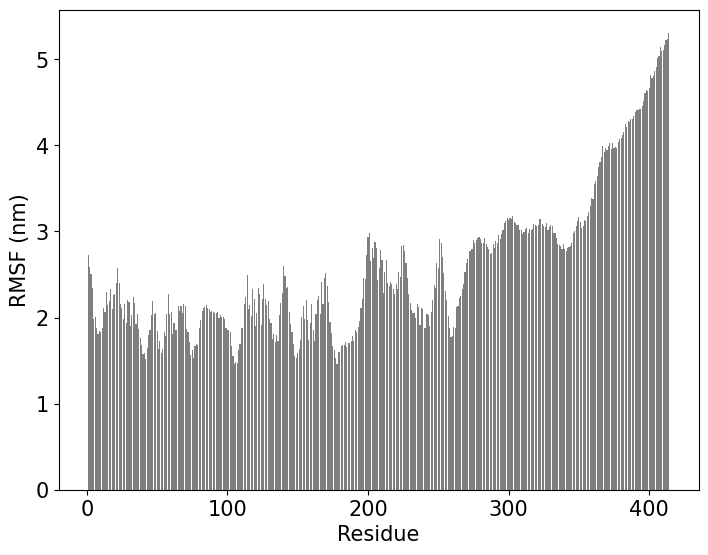

In [19]:
!echo "0" |gmx rmsf -f segment_5_input_af_rebuilt.xtc -s  segment_5_input_af_0_sys.pdb -res -o rmsf.xvg
import numpy as np
from matplotlib import  pyplot as plt
x=np.loadtxt("rmsf.xvg",comments=['#', '$', '@'])[:, 0]
y=np.loadtxt("rmsf.xvg",comments=['#', '$', '@'])[:, 1]
#print(x)
#print(y)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y,color="black",alpha=0.5)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Residue',fontsize=15)
plt.ylabel('RMSF (nm)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.legend=None
plt.savefig('rmsf.pdf',bbox_inches='tight')

Download files

In [32]:
print(home)
!pwd
!rm segment_5_input_af_*.rebuilt.xtc segment_5_input_af_*.rebuilt.pdb
!zip -r {home}/archive.zip {home}/AlphaFold-IDP/prep_run
#!zip -r {home}/archive.zip *png ../plumed.dat plumed_analysis.dat reconstruct.dat segment_5_input_af_rebuilt.xtc segment_5_input_af_0_sys.pdb rmsf.pdf ../pae_m.png FES*png FULLBIAS COLVAR ../HILLS* ../COLVAR*

/content
/content/AlphaFold-IDP/prep_run/analysis
  adding: content/AlphaFold-IDP/prep_run/ (stored 0%)
  adding: content/AlphaFold-IDP/prep_run/struct3.pdb (deflated 76%)
  adding: content/AlphaFold-IDP/prep_run/simulate_em.py (deflated 51%)
  adding: content/AlphaFold-IDP/prep_run/DISTANCE_MAP_REST.1 (deflated 59%)
  adding: content/AlphaFold-IDP/prep_run/files.zip (stored 0%)
  adding: content/AlphaFold-IDP/prep_run/HILLS.torsion1 (deflated 78%)
  adding: content/AlphaFold-IDP/prep_run/COLVAR.0 (deflated 61%)
  adding: content/AlphaFold-IDP/prep_run/GRID.torsion1 (deflated 59%)
  adding: content/AlphaFold-IDP/prep_run/plumed.dat (deflated 56%)
  adding: content/AlphaFold-IDP/prep_run/GRID.torsion2 (deflated 59%)
  adding: content/AlphaFold-IDP/prep_run/plumed_analysis.dat (deflated 56%)
  adding: content/AlphaFold-IDP/prep_run/bck.last.GRID.torsion1 (deflated 59%)
  adding: content/AlphaFold-IDP/prep_run/BAYES_rest_domains.0 (deflated 61%)
  adding: content/AlphaFold-IDP/prep_run/ge

In [33]:
from google.colab import files
files.download(home+"/archive.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>